----
# VGG-16 with Augmented Data
-----

### Summary:
Evaluating the performance of the VGG-16 model when trained on augmented data. 

### Data Overview:
- **Dataset:** MNIST Sign Language Dataset
- **Number of Samples:** Approximately 1400 images per character
- **Image Dimensions:** Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:
- **Data Augmentation**:
    - Load augmented data.

- **Training my VGG-16**:
   - Compile the model.
   - Train the model on augmented data

- **Model Evaluation**:
   - Assess the accuracy of the model on the validation dataset.
   - Analyse the model's performance using a confusion matrix and visualise misclassifications.

### Data Augmentation Reminder:

- rescale=1./255             
    > Normalisation of the input data is best when working with neural networks
- rotation_range=20          
    > To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1      
    > To ensure model is able to deal with off-centered images
- height_shift_range=0.1     
    > To ensure model is able to deal with off-centered images
- shear_range=0.2            
    > To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2             
    > Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=True       
    > To mimic opposite hand, if original image is left hand we can flip the image to show right hand

## Set Up
-----

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import random

import joblib
import math


In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Utility Functions
----

In [9]:
def img_resize(X_data, new_height, new_width, rgb= True):
    '''
        Overview:
        To resize input images to match network input layer.

        Arguments:
            - X_data: CNN model to inspect
            - new_height: input layer height
            - new_width: input layer width
            - rgb = True as default (RGB channels to 3 as default)

        Output:
            - Resized X_data
    '''
    # reshape to force X_data to have 4 dimenstions
    X_data = X_data.reshape(X_data.shape[0],X_data.shape[1],X_data.shape[2],-1)

    if rgb == True:
        # force X  to have three channels (RGB)
        X_rgb = np.repeat(X_data, 3, axis=-1) 
    else:
        pass

    # each image stored as single item in list
    resized_images = []
    for i in range(X_rgb.shape[0]):
        resized_image = tf.image.resize(X_rgb[i], size=[new_height,new_width])
        resized_images.append(resized_image)   
    
    # combines list of tensor items to single tensor item new dimenstion = num of images in list 
    X_resized = tf.stack(resized_images)
    
    return X_resized

## Data Loading
----

In [4]:
X  = joblib.load( '../../data/my_data/X.pkl' )
y = joblib.load( '../../data/my_data/y.pkl' )

In [13]:
X = X.reshape(-1,28,28)
X.shape

(34627, 28, 28)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

In [17]:
# Resize X_train and X_val to fit input dimesntions for VGG
X_train_resized = img_resize(X_train, 64, 64)
X_val_resized = img_resize(X_val, 64, 64)

### Augmented data loading

In [18]:
train_datagen = joblib.load('../../data/my_data/train_datagen.pkl') 
val_datagen = joblib.load('../../data/my_data/val_datagen.pkl') 

In [19]:
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_resized, y_val, batch_size=32)

In [20]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y, return_counts=True)

## Training the model
---

In [21]:
VGG_aug_model = load_model('../../model/my_models/VGG_model.h5')

In [23]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
# note default learning rate = 0.001
VGG_aug_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [24]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [25]:
history = VGG_aug_model.fit(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=20,
                        validation_data=val_generator,
                        validation_steps=len(val_generator),
                        callbacks=[early_stop]
                       )

Epoch 1/20


2024-07-06 20:36:00.470806: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


866/866 [==============================] - 423s 489ms/step - loss: 0.8433 - accuracy: 0.7445 - val_loss: 0.0784 - val_accuracy: 0.9851
Epoch 2/20
866/866 [==============================] - 473s 546ms/step - loss: 0.4628 - accuracy: 0.8427 - val_loss: 0.0619 - val_accuracy: 0.9896
Epoch 3/20
866/866 [==============================] - 397s 458ms/step - loss: 0.3714 - accuracy: 0.8738 - val_loss: 0.0678 - val_accuracy: 0.9809
Epoch 4/20
866/866 [==============================] - 398s 459ms/step - loss: 0.3098 - accuracy: 0.8964 - val_loss: 0.0618 - val_accuracy: 0.9835
Epoch 5/20
866/866 [==============================] - 532s 614ms/step - loss: 0.2735 - accuracy: 0.9066 - val_loss: 0.0457 - val_accuracy: 0.9900
Epoch 6/20
866/866 [==============================] - 776s 897ms/step - loss: 0.2487 - accuracy: 0.9144 - val_loss: 0.0576 - val_accuracy: 0.9820
Epoch 7/20
866/866 [==============================] - 740s 855ms/step - loss: 0.2284 - accuracy: 0.9196 - val_loss: 0.0288 - val_accura

### Saving the model

In [26]:
VGG_aug_model.save('../../model/my_models/VGG_augmented_model.h5')

### Assessing training and validation scores

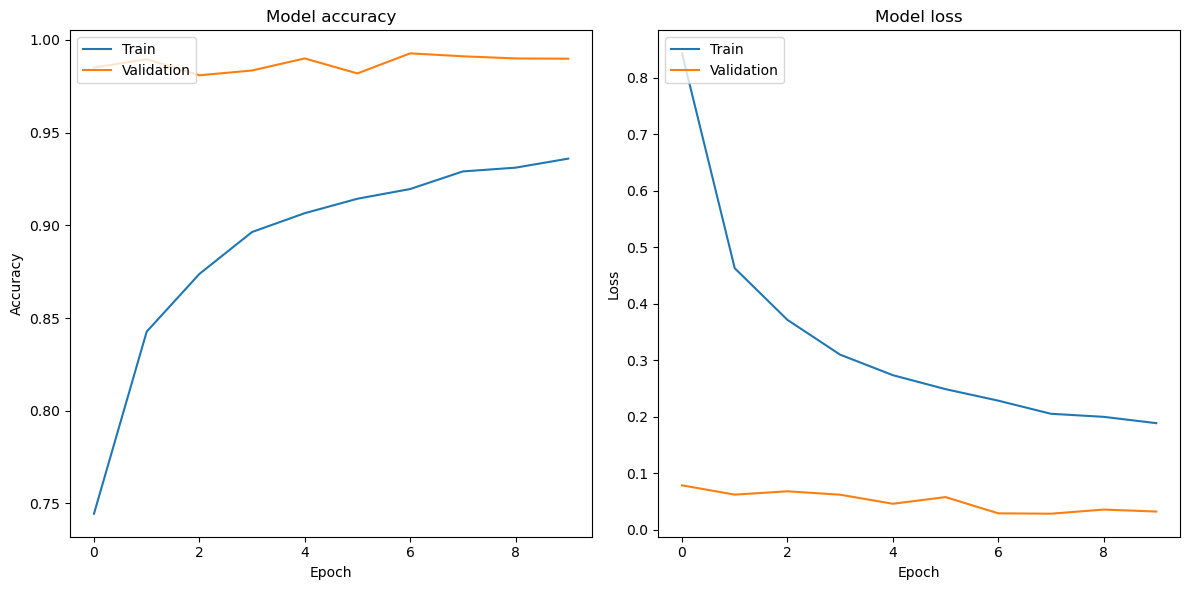

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Comment**

As expected performance of VGG with augmented data is not as good as base VGG (with original data). However, there is a positive result, the validation score is higher than the training data sugggesting the model succesfully classified letters despite augmentation.

In comparison to the CNN with augmented data, we can see VGG is more capable to deal with the augmentation in the dataset for several reasons:

- VGG-16 is a deeper network with 13 conv layers. The increase in depth allows the model to find more complex patterns.

- VGG-16 is pre-trained on a very large dataset (ImageNet) meaning its has leveraged the features previously learnt and applied them to the augmnted dataset.


In [28]:
train_loss, train_acc = VGG_aug_model.evaluate(train_generator)
print(f'VGG-16 with augmentation train score: {round(train_acc*100,4)}')

866/866 [==============================] - 640s 738ms/step - loss: 0.1837 - accuracy: 0.9370
VGG-16 with augmentation train score: 93.7006


In [29]:
val_loss, val_acc = VGG_aug_model.evaluate(val_generator)
print(f'VGG-16 with augmentation validation score: {round(val_acc*100,4)}')

217/217 [==============================] - 164s 754ms/step - loss: 0.0320 - accuracy: 0.9899
VGG-16 with augmentation validation score: 98.9893


## Model Evaluation
-----

In [30]:
VGG_aug_model = load_model('../../model/my_models/VGG_augmented_model.h5')

### Confusion Matrix

In [53]:
# Calculate the predicted labels for each test image.
soft_pred = VGG_aug_model.predict(X_val_resized)
pred_y = np.argmax(soft_pred, axis=1)

217/217 [==============================] - 165s 759ms/step


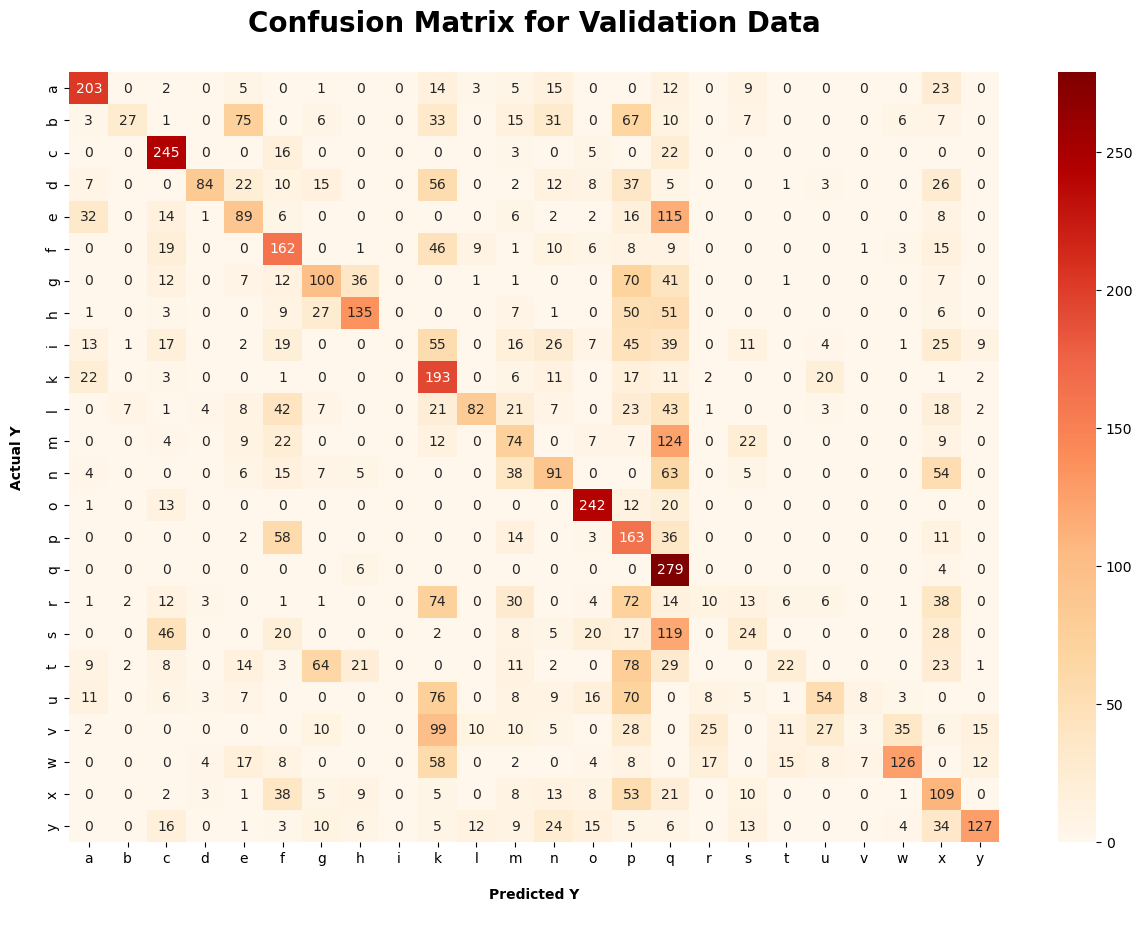

In [55]:
from sklearn.metrics import confusion_matrix

# Create the confusion matrix using sklearn
conf_mat = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat,
            annot=True,
            fmt = 'd',
            cmap="OrRd",
           )
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Comment:**

This confusion matrix doesn't look correct.

I believe it is beacuse I am using X_val_resized and y_val to build the confusion matrix and that is why the number of misclassifications I am seeing is higher than expected. I suspect this is due to the batching when using val_generator.

To be investigated.

### Testing an Unseen Input Image

In [62]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(64, 64))
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

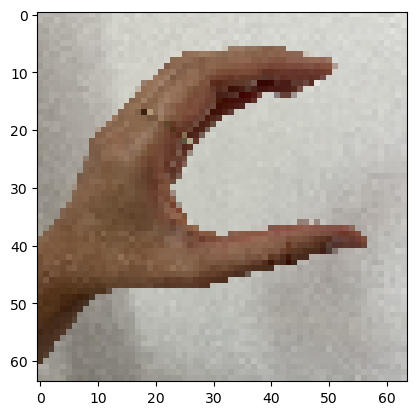

In [63]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [64]:
image_array = img_to_array(input_image)
test_img = image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2])

In [65]:
soft_pred = VGG_aug_model.predict(test_img)
pred_y = np.argmax(soft_pred, axis=1)

1/1 [==============================] - 0s 55ms/step


In [66]:
print(f'Prediction using VGG trained with augmented data: \n{alphabet[pred_y[0]].upper()}')

Prediction using VGG trained with augmented data: 
C


## Conclusion
-----

|                  | VGG        | VGG with augmentation |
|------------------|------------|-----------------------|
| Train Score      | 99.98      | 93.70                 |
| Validation Score | 99.83      | 98.98                 |

The VGG model trained on the original dataset achieved almost 100% accuracy indicating performance on the original data was very strong. 

The VGG model trained on augmented data performed worse since augmentation introduces some variability into the dataset which can cause the model to get confused. 

Despite this, the VGG model with augmentation received a higher validation accuray score. This result shows us that the data augmentation helped the model to generalise to unseen data better. Going forward, we will be using the base VGG model to perform some fine-tuning, however if I had more time I would be interested to fine tune the VGG model with augmented data and see how this performs with real world data.

